In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [153]:
import itertools

def add_panel_letters(fig, axes=None, fontsize=30, xpos=-0.04, ypos=1.05):
    labels = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    
    if axes is None:
        axes = fig.get_axes()

    if type(xpos) == float:
        xpos = itertools.repeat(xpos)
    if type(ypos) == float:
        ypos = itertools.repeat(ypos)

    for i, (ax, x, y) in enumerate(zip(axes, xpos, ypos)):
        ax.text(x, y, labels[i],
                transform=ax.transAxes, size=fontsize, weight='bold')

In [74]:
dfs = pd.read_pickle("../run/Taa/meshdep/results.pkl")

dfs['tdur'] = dfs['tto'] - dfs['tfr']

In [75]:
df0a = dfs[dfs.model == 'propwaves0a'].sort_values(['subject', 'rec', 'contact']).reset_index()
df0b = dfs[dfs.model == 'propwaves0b'].sort_values(['subject', 'rec', 'contact']).reset_index()
df1 = dfs[dfs.model == 'propwaves1'].sort_values(['subject', 'rec', 'contact']).reset_index()


for df in [df0a, df0b, df1]:
    df['group'] = 0
    df.loc[df.is_seizing, 'group'] = 1
    df.loc[df.is_taa, 'group'] = 2
    # df.loc[df.is_ingroup, 'group'] = 3

In [161]:
fitmtx1 = np.zeros((3,3), dtype=int)
fitmtx2 = np.zeros((3,3), dtype=int)

for i in range(3):
    for j in range(3):
        fitmtx1[i, j] = np.sum((df0a.group == i) & (df1.group == j))
        fitmtx2[i, j] = np.sum((df0a.group == i) & (df0b.group == j))
        
fitmtcs = [fitmtx1, fitmtx2]

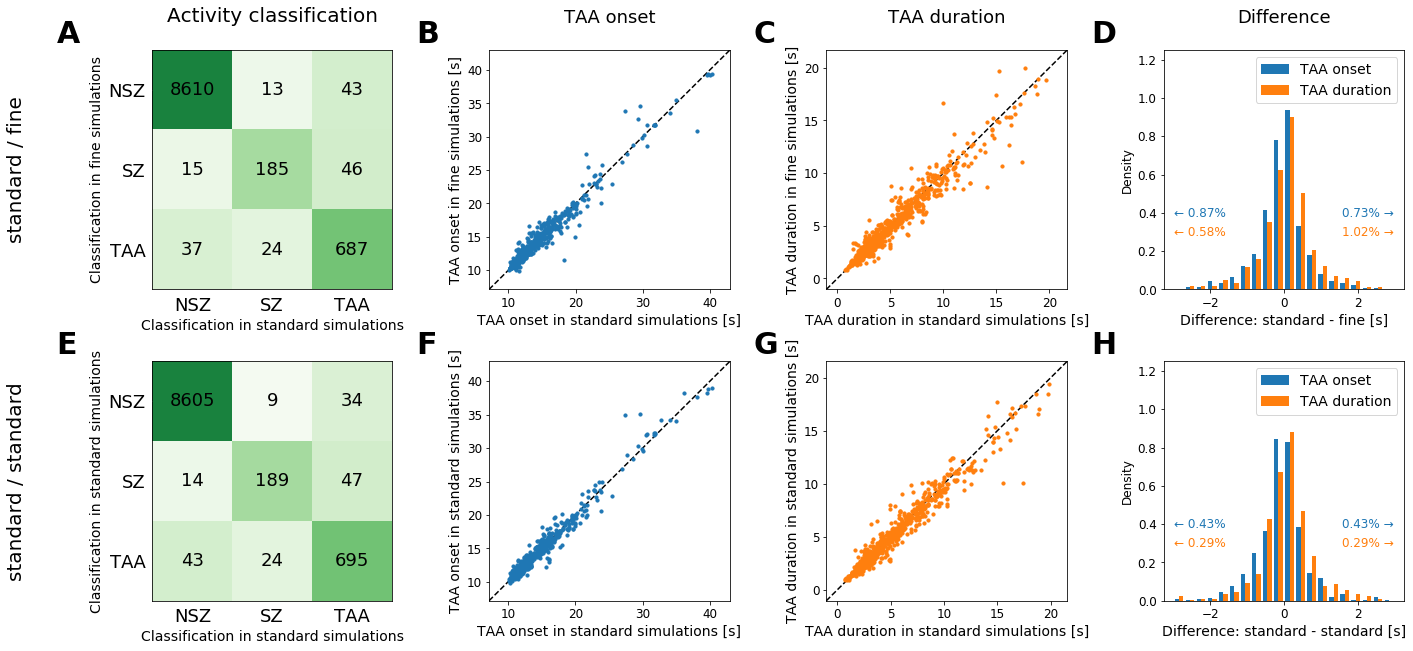

In [165]:
sims = [('standard', 'fine'), ('standard', 'standard')]

fig = plt.figure(figsize=(20, 9))

for k, (dfa, dfb) in enumerate([(df0a, df1), (df0a, df0b)]):
    ax = plt.subplot2grid((2, 4), (k, 0))
    if k == 0:
        plt.title("Activity classification\n", fontsize=20)
    
    fitmtx = fitmtcs[k]
    plt.imshow(np.log(fitmtx.T), cmap='Greens', vmin=2, vmax=11)
    
    plt.xticks([0, 1, 2], ['NSZ', 'SZ', 'TAA'], fontsize=18)
    plt.yticks([0, 1, 2], ['NSZ', 'SZ', 'TAA'], fontsize=18)
    plt.xlim([-0.5, 2.5])
    plt.ylim([2.5, -0.5])
    
    plt.xlabel(f"Classification in {sims[k][0]} simulations", fontsize=14)
    plt.ylabel(f"Classification in {sims[k][1]} simulations", fontsize=14)
    plt.text(-2.2, 1, f"{sims[k][0]} / {sims[k][1]}", fontsize=20, va='center', ha='center', clip_on=False, rotation='vertical')
    
    ax.tick_params(axis='both', which='both', color='w')
    
    for i in range(3):
        for j in range(3):
            plt.text(i, j, fitmtx[i, j], ha='center', va='center', fontsize=18)

    
    
    tmask = dfa.is_taa & dfb.is_taa
    dff0 = dfa[tmask]
    dff1 = dfb[tmask]
    
    colors = ['tab:blue', 'tab:orange']
    for i, (var, name) in enumerate([('tfr', 'TAA onset'), ('tdur', 'TAA duration')]):
        ax = plt.subplot2grid((2, 4), (k, i+1))
        
        if k == 0:
            plt.title(name + "\n", fontsize=18)
        
        plt.scatter(dff0[var], dff1[var], s=10, color=colors[i])
        
        fmin = min(dff0[var].min(), dff1[var].min())
        fmax = max(dff0[var].max(), dff1[var].max())
        fdelta = fmax - fmin    
        fmin -= 0.09 * fdelta
        fmax += 0.09 * fdelta    
        plt.plot([fmin, fmax], [fmin, fmax], 'k--', zorder=-1)
        plt.xlim(fmin, fmax)
        plt.ylim(fmin, fmax)
        
        plt.xlabel(f"{name} in {sims[k][0]} simulations [s]", fontsize=14)
        plt.ylabel(f"{name} in {sims[k][1]} simulations [s]", fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)

    
    
    ax = plt.subplot2grid((2, 4), (k, 3))
    if k == 0:
        plt.title("Difference\n", fontsize=18)
    
    dtfr = dff0.tfr - dff1.tfr
    ddur = dff0.tdur - dff1.tdur
    plt.hist([dtfr, ddur], bins=np.linspace(-3, 3, 21), label=["TAA onset", "TAA duration"], density=True)
    plt.legend(loc='upper right', fontsize=14)
    plt.ylim(0, 1.25)
    plt.ylabel("Density", fontsize=12)
    plt.xlabel(f"Difference: {sims[k][0]} - {sims[k][1]} [s]", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.text(-2.98, 0.4, f"← {100 * np.mean(dtfr < -3.):4.2f}%", color='tab:blue',   fontsize=12, ha='left', va='center')
    plt.text(-2.98, 0.3, f"← {100 * np.mean(ddur < -3.):4.2f}%", color='tab:orange', fontsize=12, ha='left', va='center')
    plt.text( 2.98, 0.4, f"{100 * np.mean(dtfr > 3.):4.2f}% →",  color='tab:blue',   fontsize=12, ha='right', va='center')
    plt.text( 2.98, 0.3, f"{100 * np.mean(ddur > 3.):4.2f}% →",  color='tab:orange', fontsize=12, ha='right', va='center')
    
add_panel_letters(fig, xpos=[-0.4, -0.3, -0.3, -0.3, -0.4, -0.3, -0.3, -0.3], ypos=1.03)
    
plt.subplots_adjust(left=0.11, right=0.98, top=0.92, bottom=0.07, wspace=0.4, hspace=0.3)
plt.savefig("figs/meshdep.pdf")